#Initializing project

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import time

#for google access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = "../content/drive/My Drive/CSCI_534 Project/Project/Gamestop Data"
# project_path = './'

gm_stock = pd.read_csv(project_path+'/Gamestop Stock Data.csv') #181 of sample
gm1_vader = pd.read_csv(project_path+'/gamestop_vader1.csv',index_col=0)
gm2_vader = pd.read_csv(project_path+'/gamestop_vader2.csv',index_col=0)
#combining gm data
gm_vader = pd.concat([gm1_vader,gm2_vader])
gm_vader.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1042457, 7)

In [3]:

gm_vader = gm_vader.dropna(subset=['Datetime','Text','scores'])

In [4]:
gm_vader.shape #1042457
#613705 is only available

(613705, 7)

# Preparing data
In this part, we will combine and prepare the data is neccessary for the model to learn such as date, stock price and vader scores.

In [5]:
#In this part we are preparing data for processing (taking datetime and scores from vader data)
gm_vader_date = gm_vader['Datetime'].to_numpy()
gm_vader_scores = gm_vader['scores'].to_numpy()

NEG = 1
NEU = 3
POS = 5
COM = -1 #remove '}'

In [6]:
#Cleaning gm data
gm_vader_neg =[]
gm_vader_neu =[]
gm_vader_pos =[]
gm_vader_com =[] #don't know if needed
for i in range(len(gm_vader_date)):
  gm_vader_date[i] = gm_vader_date[i].split()[0]    #cleaning the data only the date
  #change date fromat
  #mm/dd/yyy
  gm_vader_date[i]=time.strptime(gm_vader_date[i],'%Y-%m-%d') 
  gm_vader_date[i]=time.strftime('%m/%d/%Y',gm_vader_date[i])

  res = gm_vader_scores[i].replace(',','').split()
  gm_vader_neg.append(float(res[NEG]))
  gm_vader_neu.append(float(res[NEU]))
  gm_vader_pos.append(float(res[POS]))
  gm_vader_com.append(float(res[COM].replace("}","")))

In [7]:
#put gm vader data in df
gm_vader_df = pd.DataFrame({
    'Date':gm_vader_date,
    'neg':gm_vader_neg,
    'neu':gm_vader_neu,
    'pos':gm_vader_pos,
    'com':gm_vader_com
})
#combine data on the same date(caculate the descriptive statistics of "neg","neu","pos","com")
#mean
gm_vader_df_mean = gm_vader_df.groupby(['Date']).agg({'neg':np.mean,'neu':np.mean,'pos':np.mean,'com':np.mean}).reset_index()
#median
gm_vader_df_median = gm_vader_df.groupby(['Date']).agg({'neg':np.median,'neu':np.median,'pos':np.median,'com':np.median}).reset_index()
#std
gm_vader_df_std = gm_vader_df.groupby(['Date']).agg({'neg':np.std,'neu':np.std,'pos':np.std,'com':np.std}).reset_index()
#max
gm_vader_df_max = gm_vader_df.groupby(['Date']).agg({'neg':np.max,'neu':np.max,'pos':np.max,'com':np.max}).reset_index()
#min
gm_vader_df_min = gm_vader_df.groupby(['Date']).agg({'neg':np.min,'neu':np.min,'pos':np.min,'com':np.min}).reset_index()
#skewness
gm_vader_df_skewness = gm_vader_df.groupby(['Date']).agg({'neg':stats.skew,'neu':stats.skew,'pos':stats.skew,'com':stats.skew}).reset_index()
#kurtosis
gm_vader_df_kurtosis = gm_vader_df.groupby(['Date']).agg({'neg':stats.kurtosis,'neu':stats.kurtosis,'pos':stats.kurtosis,'com':stats.kurtosis}).reset_index()
#Jarque-Bera
#To test if the data have normal distribution base on skewness and kurotsis

In [8]:
#clean the stock date(taking datetime and close from stock data)
gm_stock_date = gm_stock['Date'].to_numpy()
gm_stock_close = gm_stock['Close'].to_numpy()

In [9]:
#get stock date and change format
for i in range(len(gm_stock_date)):
  gm_stock_date[i] = gm_stock_date[i].split()[0]
  gm_stock_date[i]=time.strptime(gm_stock_date[i],'%m/%d/%Y')
  gm_stock_date[i]=time.strftime('%m/%d/%Y',gm_stock_date[i])

In [10]:
#put gm stock data in df
gm_stock_df = pd.DataFrame({
    'Date':gm_stock_date,
    'close':gm_stock_close
})

#normalizing the stock value
gm_stock_df['close'] = (gm_stock_df['close'] - gm_stock_df['close'].min()) / (gm_stock_df['close'].max() - gm_stock_df['close'].min())
gm_stock_df

,Date,close
0,07/01/2020,0.001717
1,07/02/2020,0.001280
2,07/06/2020,0.001135
3,07/07/2020,0.000698
4,07/08/2020,0.001193
...,...,...
176,03/15/2021,0.629372
177,03/16/2021,0.594541
178,03/17/2021,0.599313
179,03/18/2021,0.575860


In [11]:
#merge vader mean data and stock data
gm_merge_df_mean = pd.merge(gm_vader_df_mean,gm_stock_df,on='Date',how="left")
gm_merge_df_mean = gm_merge_df_mean.dropna().reset_index(drop=True)
gm_merge_df_mean.shape #Only 20 days worth of data

#median
gm_merge_df_median = pd.merge(gm_vader_df_median,gm_stock_df,on='Date',how="left")
gm_merge_df_median = gm_merge_df_median.dropna().reset_index(drop=True)

#std
gm_merge_df_std = pd.merge(gm_vader_df_std,gm_stock_df,on='Date',how="left")
gm_merge_df_std = gm_merge_df_std.dropna().reset_index(drop=True)

#max
gm_merge_df_max = pd.merge(gm_vader_df_max,gm_stock_df,on='Date',how="left")
gm_merge_df_max = gm_merge_df_max.dropna().reset_index(drop=True)

#min
gm_merge_df_min = pd.merge(gm_vader_df_min,gm_stock_df,on='Date',how="left")
gm_merge_df_min = gm_merge_df_min.dropna().reset_index(drop=True)


In [12]:
gm_merge_df_mean[['neg','neu','pos','com']][:-10].shape[0]

36

In [13]:
gm_merge_df_mean.shape

(46, 6)

# Training the linear model

Training the linear model for Gamestop (all feature)

In [14]:
#Creating a model based on the gm data
#gm_merge_df[['neg','neu','pos','com']] is the data or x or feature
#gm_merge_df[['close']] is the label
#mean
reg_gm_mean = LinearRegression().fit(gm_merge_df_mean[['neg','neu','pos','com']][:-10], gm_merge_df_mean[['close']][:-10])
#median
reg_gm_median = LinearRegression().fit(gm_merge_df_median[['neg','neu','pos','com']][:-10], gm_merge_df_median[['close']][:-10])
#std
reg_gm_std = LinearRegression().fit(gm_merge_df_std[['neg','neu','pos','com']][:-10], gm_merge_df_std[['close']][:-10])
#max
reg_gm_max = LinearRegression().fit(gm_merge_df_max[['neg','neu','pos','com']][:-10], gm_merge_df_max[['close']][:-10])
#min
reg_gm_min = LinearRegression().fit(gm_merge_df_min[['neg','neu','pos','com']][:-10], gm_merge_df_min[['close']][:-10])

# Plot the data and model of for each base line

Predict AMC model with all feature

In [15]:
#each model is predicting the label using the data that we have
#pred_gm is a numpy array consisting the values of prediction of the gm data that we use for the training
#mean 
pred_gm_mean = reg_gm_mean.predict(gm_merge_df_mean[['neg','neu','pos','com']][-10:])
#median
pred_gm_median = reg_gm_median.predict(gm_merge_df_median[['neg','neu','pos','com']][-10:])
#std
pred_gm_std = reg_gm_std.predict(gm_merge_df_std[['neg','neu','pos','com']][-10:])
#max
pred_gm_max = reg_gm_max.predict(gm_merge_df_max[['neg','neu','pos','com']][-10:])
#min
pred_gm_min = reg_gm_min.predict(gm_merge_df_min[['neg','neu','pos','com']][-10:])

#To plot the training model
#mean 
train_gm_mean = reg_gm_mean.predict(gm_merge_df_mean[['neg','neu','pos','com']][:-10])
#median
train_gm_median = reg_gm_median.predict(gm_merge_df_median[['neg','neu','pos','com']][:-10])
#std
train_gm_std = reg_gm_std.predict(gm_merge_df_std[['neg','neu','pos','com']][:-10])
#max
train_gm_max = reg_gm_max.predict(gm_merge_df_max[['neg','neu','pos','com']][:-10])
#min
train_gm_min = reg_gm_min.predict(gm_merge_df_min[['neg','neu','pos','com']][:-10])


#In this part, I am combining the data  of each company with the prediction
#mean
gm_merge_pred_mean = pd.concat([gm_merge_df_mean[:-10], pd.DataFrame(train_gm_mean,columns=['pred'])], axis=1)
#median
gm_merge_pred_median = pd.concat([gm_merge_df_median[:-10], pd.DataFrame(train_gm_median,columns=['pred'])], axis=1)
#std
gm_merge_pred_std = pd.concat([gm_merge_df_std[:-10], pd.DataFrame(train_gm_std,columns=['pred'])], axis=1)
#max
gm_merge_pred_max = pd.concat([gm_merge_df_max[:-10], pd.DataFrame(train_gm_max,columns=['pred'])], axis=1)
#min
gm_merge_pred_min = pd.concat([gm_merge_df_min[:-10], pd.DataFrame(train_gm_min,columns=['pred'])], axis=1)

Display the perfomance of the model

In [16]:
from sklearn.metrics import mean_squared_error

#This is the score of the prediction/ performance of the model
#mean
gm_score_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_mean)
#median
gm_score_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_median)
#std
gm_score_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_std)
#max
gm_score_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_max)
#min
gm_score_min = mean_squared_error(gm_merge_df_min[['close']][-10:], pred_gm_min)
[gm_score_mean,gm_score_median,gm_score_std,gm_score_max,gm_score_min]

[0.002513873161386136,
 0.007420275952812869,
 0.0030334807212727224,
 0.01062042194300853,
 0.007930328373083769]

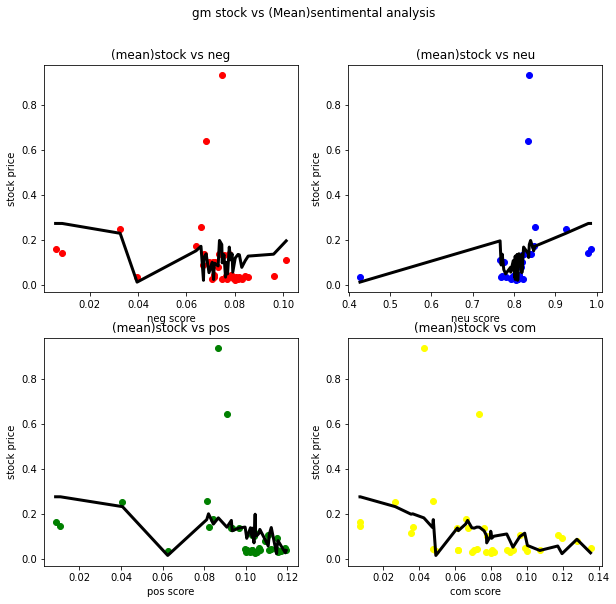

In [17]:
#plot gm
#In this part, it is plotting the data with the stock + the model itself
#Mean sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Mean)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_mean = gm_merge_pred_mean.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_mean[['neg']],gm_sort_neg_mean[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_mean[['neg']], gm_sort_neg_mean[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(mean)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_mean = gm_merge_pred_mean.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_mean[['neu']],gm_sort_neu_mean[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_mean[['neu']], gm_sort_neu_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(mean)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_mean = gm_merge_pred_mean.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_mean[['pos']],gm_sort_pos_mean[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_mean[['pos']], gm_sort_pos_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(mean)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_mean = gm_merge_pred_mean.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_mean[['com']],gm_sort_com_mean[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_mean[['com']], gm_sort_com_mean[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(mean)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

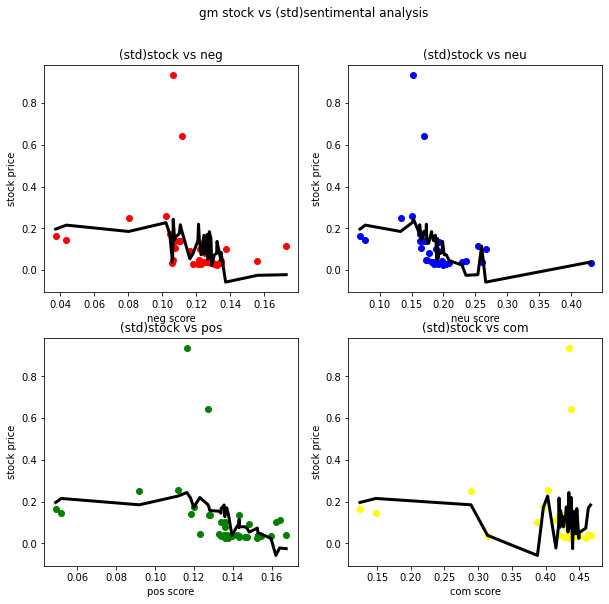

In [18]:
#std sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (std)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_std = gm_merge_pred_std.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_std[['neg']],gm_sort_neg_std[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_std[['neg']], gm_sort_neg_std[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(std)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_std = gm_merge_pred_std.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_std[['neu']],gm_sort_neu_std[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_std[['neu']], gm_sort_neu_std[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(std)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_std = gm_merge_pred_std.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_std[['pos']],gm_sort_pos_std[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_std[['pos']], gm_sort_pos_std[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(std)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_std = gm_merge_pred_std.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_std[['com']],gm_sort_com_std[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_std[['com']], gm_sort_com_std[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(std)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

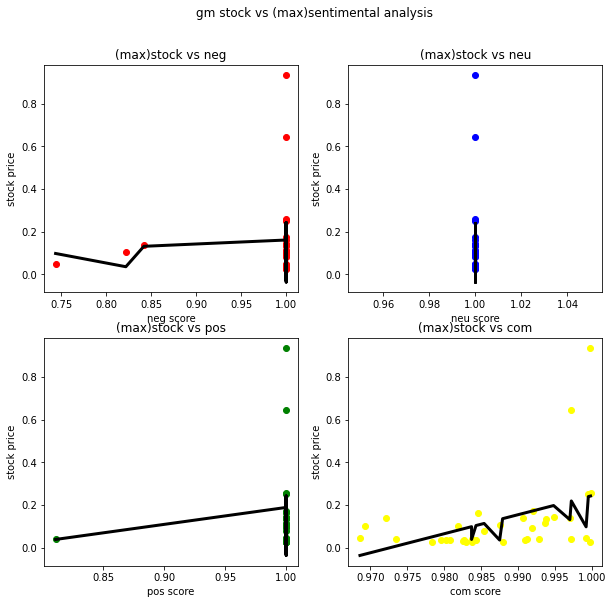

In [19]:
#Max sentimental analysis
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (max)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_max = gm_merge_pred_max.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_max[['neg']],gm_sort_neg_max[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_max[['neg']], gm_sort_neg_max[['pred']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('(max)stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_max = gm_merge_pred_max.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_max[['neu']],gm_sort_neu_max[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_max[['neu']], gm_sort_neu_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('(max)stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_max = gm_merge_pred_max.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_max[['pos']],gm_sort_pos_max[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_max[['pos']], gm_sort_pos_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('(max)stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_max = gm_merge_pred_max.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_max[['com']],gm_sort_com_max[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_max[['com']], gm_sort_com_max[['pred']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('(max)stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

#Plot data against time

Plotting Gamestop stock with mean sentimental analysis

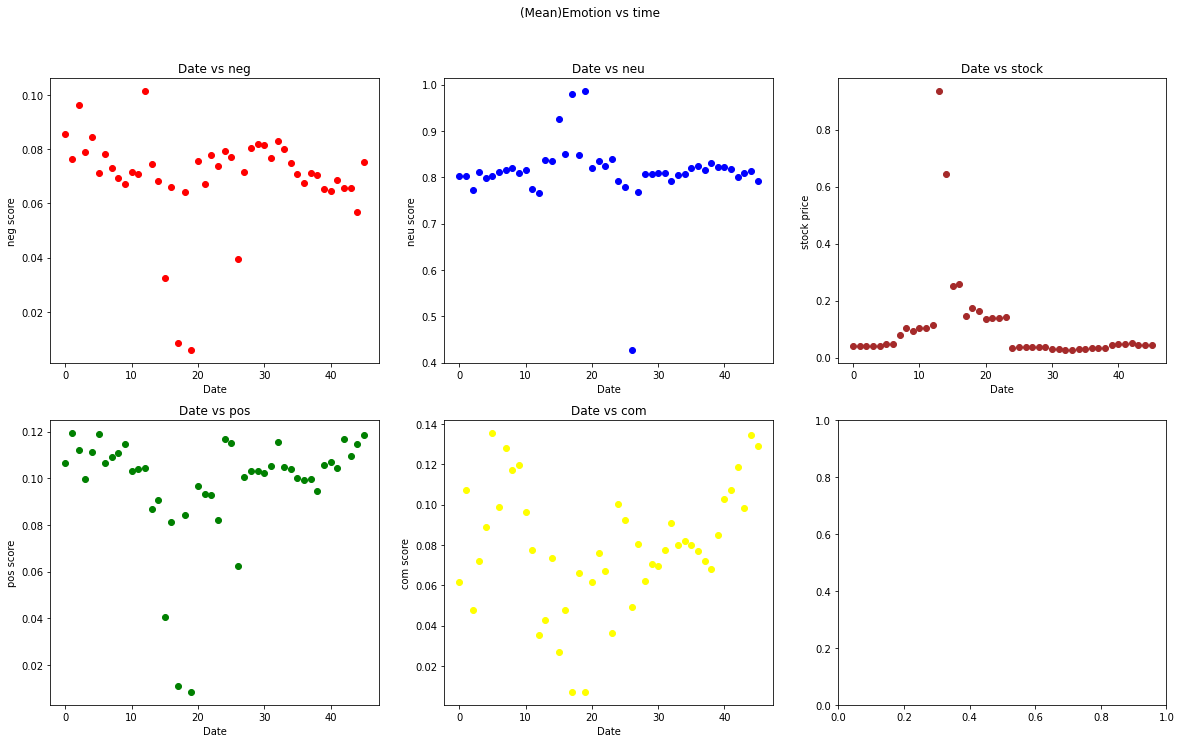

In [20]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(Mean)Emotion vs time')
fig.set_size_inches(20,10)

gm_sort_neg_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_neg_mean.shape[0])],gm_sort_neg_mean[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

gm_sort_neu_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_neu_mean.shape[0])],gm_sort_neu_mean[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

gm_sort_pos_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_pos_mean.shape[0])],gm_sort_pos_mean[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

gm_sort_com_mean = gm_merge_df_mean.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_com_mean.shape[0])],gm_sort_com_mean[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

gm_sort_date = gm_merge_df_mean.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

In [21]:
gm_sort_neg_mean.shape[0]

46

Plotting Gamestop stock with median sentimental analysis

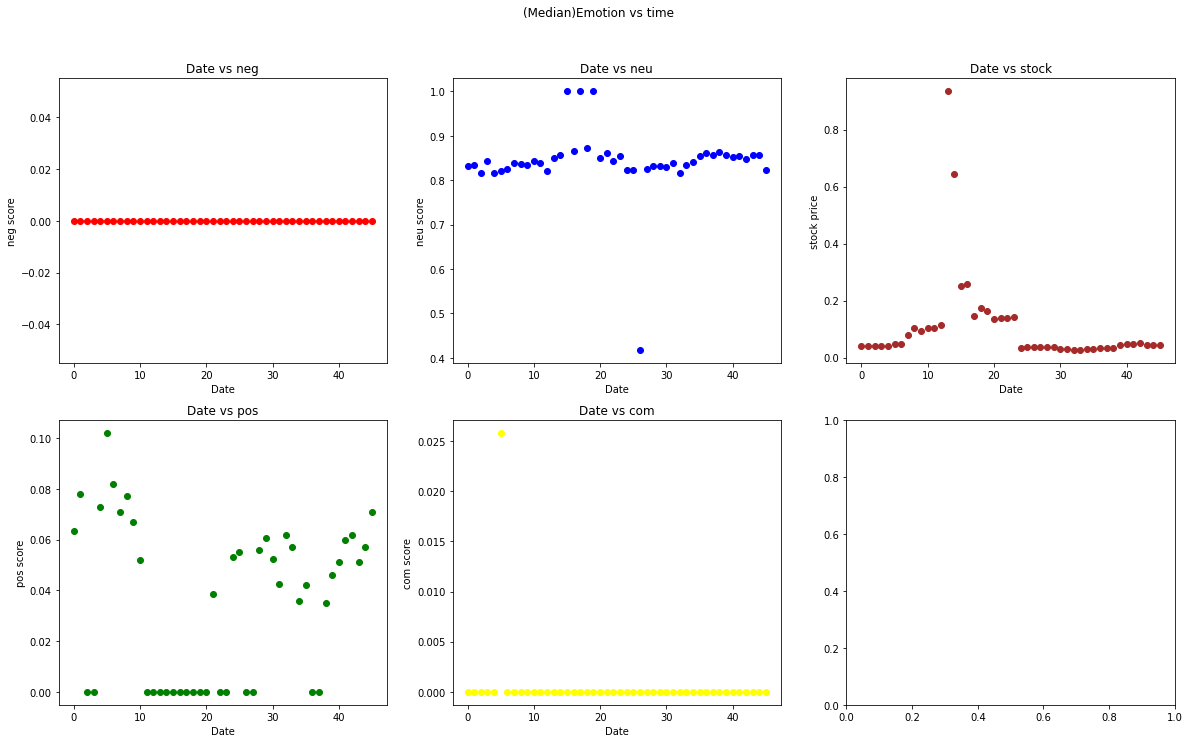

In [22]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(Median)Emotion vs time')
fig.set_size_inches(20,10)

gm_sort_neg_median = gm_merge_df_median.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_neg_median.shape[0])],gm_sort_neg_median[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

gm_sort_neu_median = gm_merge_df_median.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_neu_median.shape[0])],gm_sort_neu_median[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

gm_sort_pos_median = gm_merge_df_median.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_pos_median.shape[0])],gm_sort_pos_median[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

gm_sort_com_median = gm_merge_df_median.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_com_median.shape[0])],gm_sort_com_median[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

gm_sort_date = gm_merge_df_median.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting gamestop stock with std sentimental analysis

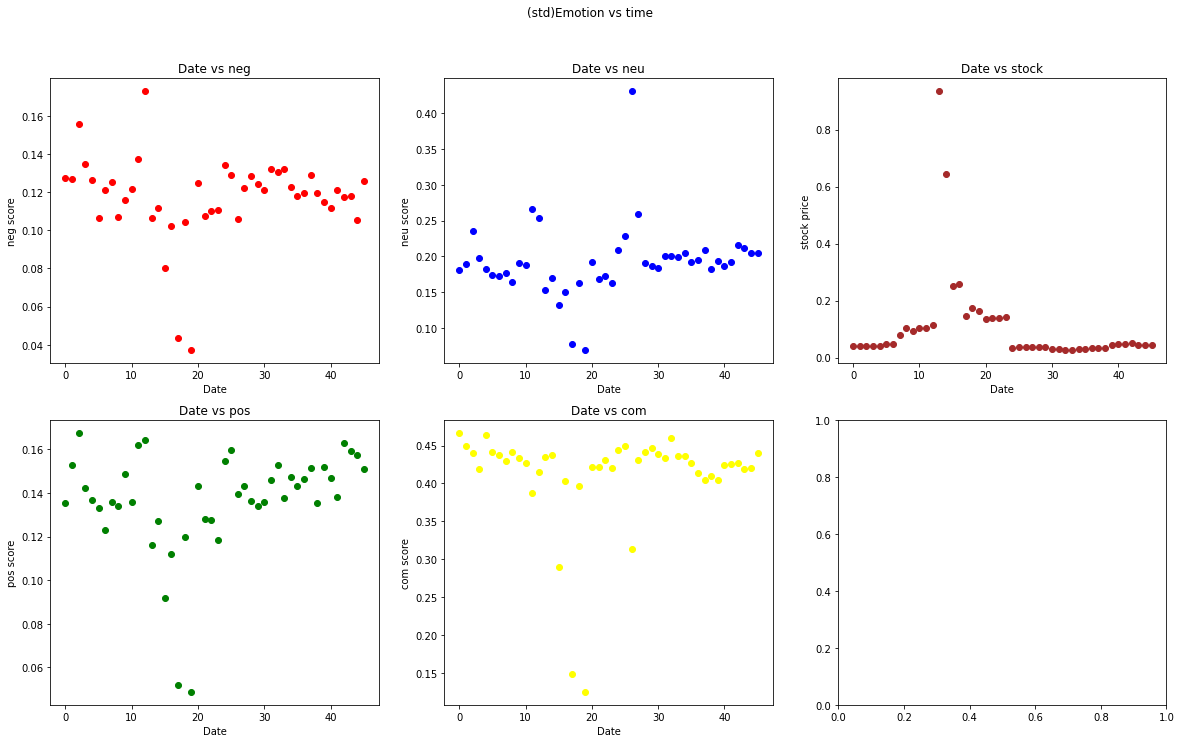

In [23]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(std)Emotion vs time')
fig.set_size_inches(20,10)

gm_sort_neg_std = gm_merge_df_std.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_neg_std.shape[0])],gm_sort_neg_std[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

gm_sort_neu_std = gm_merge_df_std.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_neu_std.shape[0])],gm_sort_neu_std[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

gm_sort_pos_std = gm_merge_df_std.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_pos_std.shape[0])],gm_sort_pos_std[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

gm_sort_com_std = gm_merge_df_std.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_com_std.shape[0])],gm_sort_com_std[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

gm_sort_date = gm_merge_df_std.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting Gamestop stock with maximum sentimental analysis

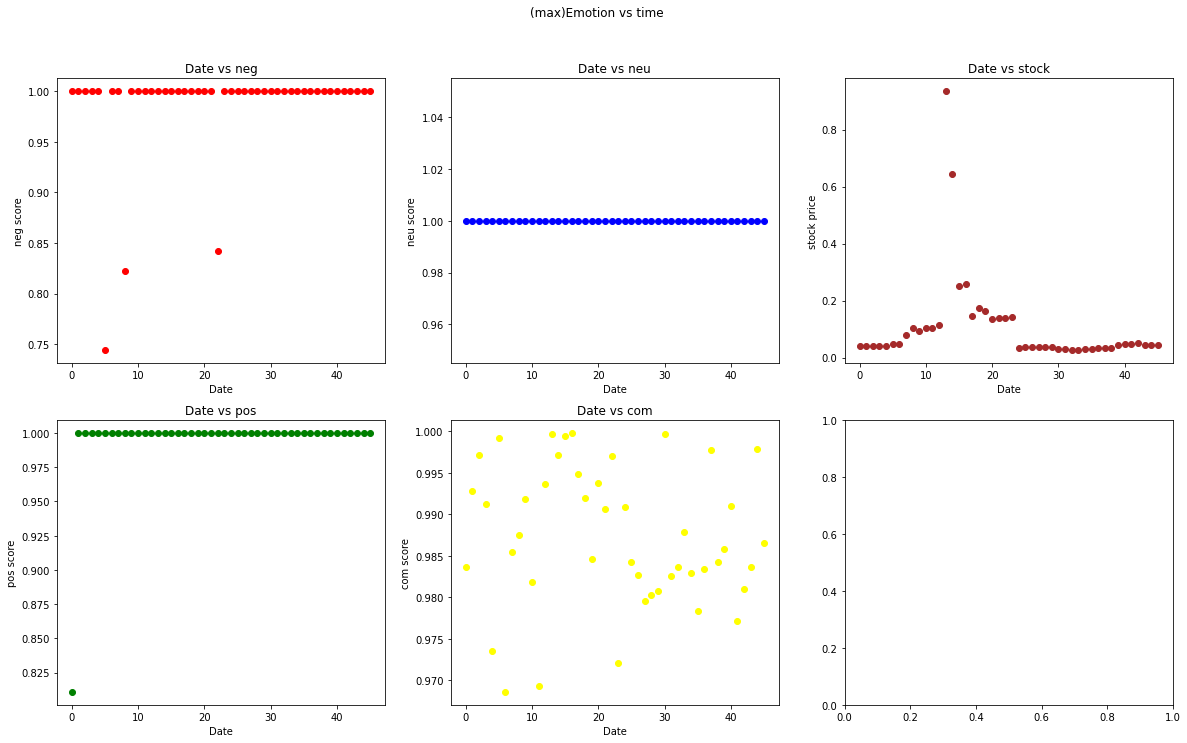

In [24]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(max)Emotion vs time')
fig.set_size_inches(20,10)

gm_sort_neg_max = gm_merge_df_max.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_neg_max.shape[0])],gm_sort_neg_max[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

gm_sort_neu_max = gm_merge_df_max.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_neu_max.shape[0])],gm_sort_neu_max[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

gm_sort_pos_max = gm_merge_df_max.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_pos_max.shape[0])],gm_sort_pos_max[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

gm_sort_com_max = gm_merge_df_max.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_com_max.shape[0])],gm_sort_com_max[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

gm_sort_date = gm_merge_df_max.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

Plotting AMC stock with minimum sentimental analysis

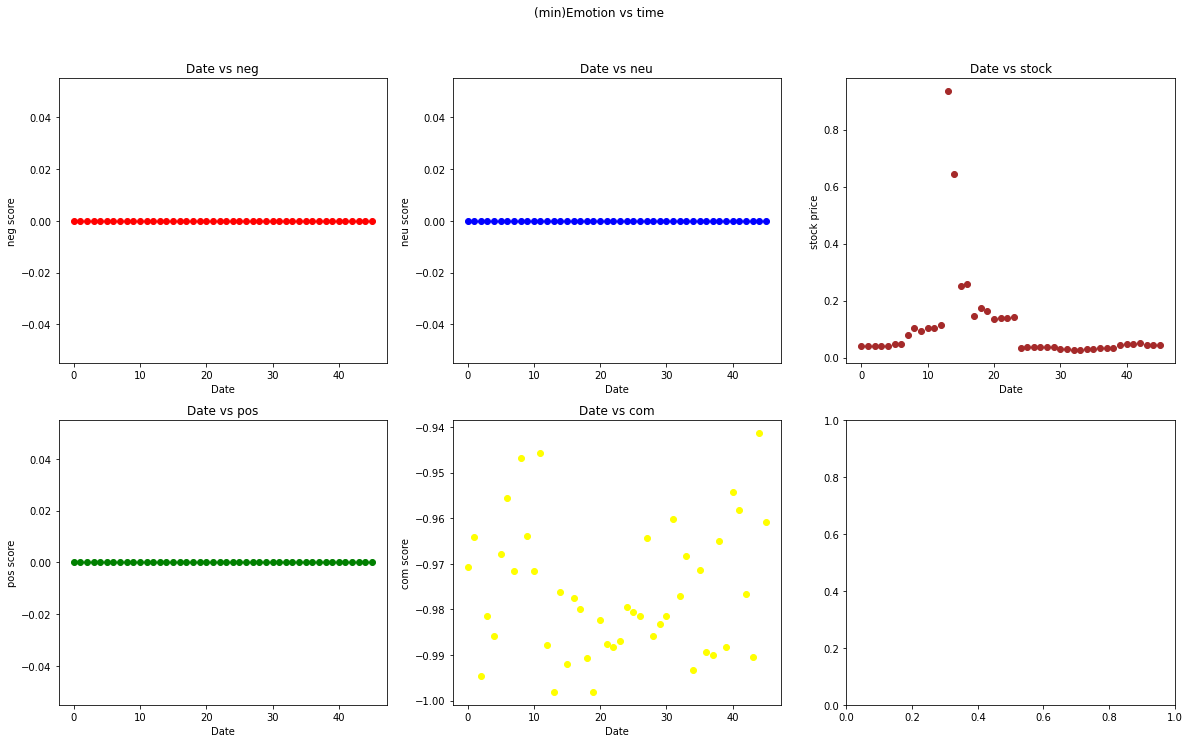

In [25]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('(min)Emotion vs time')
fig.set_size_inches(20,10)

gm_sort_neg_min = gm_merge_df_min.sort_values(by=['Date'])
axs[0,0].scatter([i for i in range(gm_sort_neg_min.shape[0])],gm_sort_neg_min[['neg']],color='red',label='neg')
axs[0,0].set_title('Date vs neg')
axs[0,0].set(xlabel='Date', ylabel='neg score')

gm_sort_neu_min = gm_merge_df_min.sort_values(by=['Date'])
axs[0,1].scatter([i for i in range(gm_sort_neu_min.shape[0])],gm_sort_neu_min[['neu']],color='blue',label='neu')
axs[0,1].set_title('Date vs neu')
axs[0,1].set(xlabel='Date', ylabel='neu score')

gm_sort_pos_min = gm_merge_df_min.sort_values(by=['Date'])
axs[1,0].scatter([i for i in range(gm_sort_pos_min.shape[0])],gm_sort_pos_min[['pos']],color='green',label='pos')
axs[1,0].set_title('Date vs pos')
axs[1,0].set(xlabel='Date', ylabel='pos score')

gm_sort_com_min = gm_merge_df_min.sort_values(by=['Date'])
axs[1,1].scatter([i for i in range(gm_sort_com_min.shape[0])],gm_sort_com_min[['com']],color='yellow',label='com')
axs[1,1].set_title('Date vs com')
axs[1,1].set(xlabel='Date', ylabel='com score')

gm_sort_date = gm_merge_df_min.sort_values(by=['Date'])
axs[0,2].scatter([i for i in range(gm_sort_date.shape[0])],gm_sort_date[['close']],color='brown',label='stock')
axs[0,2].set_title('Date vs stock')
axs[0,2].set(xlabel='Date', ylabel='stock price')
plt.show()

#Training with different method

In [26]:
#Training models based on the gm data for four features(neg,neu,pos,com) separately
reg_gm_neg_mean = LinearRegression().fit(gm_merge_df_mean[['neg']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_neu_mean = LinearRegression().fit(gm_merge_df_mean[['neu']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_pos_mean = LinearRegression().fit(gm_merge_df_mean[['pos']][:-10], gm_merge_df_mean[['close']][:-10])
reg_gm_com_mean = LinearRegression().fit(gm_merge_df_mean[['com']][:-10], gm_merge_df_mean[['close']][:-10])

In [27]:
#predict the stock price of gm using new models
pred_gm_neg_mean = reg_gm_neg_mean.predict(gm_merge_df_mean[['neg']][-10:])
pred_gm_neu_mean = reg_gm_neu_mean.predict(gm_merge_df_mean[['neu']][-10:])
pred_gm_pos_mean = reg_gm_pos_mean.predict(gm_merge_df_mean[['pos']][-10:])
pred_gm_com_mean = reg_gm_com_mean.predict(gm_merge_df_mean[['com']][-10:])

#predict on the training model to plot the data
train_gm_neg_mean = reg_gm_neg_mean.predict(gm_merge_df_mean[['neg']][:-10])
train_gm_neu_mean = reg_gm_neu_mean.predict(gm_merge_df_mean[['neu']][:-10])
train_gm_pos_mean = reg_gm_pos_mean.predict(gm_merge_df_mean[['pos']][:-10])
train_gm_com_mean = reg_gm_com_mean.predict(gm_merge_df_mean[['com']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_mean = pd.concat([gm_merge_df_mean[:-10], pd.DataFrame(train_gm_neg_mean,columns=['pred_neg'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_neu_mean,columns=['pred_neu'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_pos_mean,columns=['pred_pos'])], axis=1)
gm_merge_pred1_mean = pd.concat([gm_merge_pred1_mean, pd.DataFrame(train_gm_com_mean,columns=['pred_com'])], axis=1)

gm_merge_pred1_mean

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.085593,0.802887,0.106741,0.061700,0.038992,0.101429,0.118114,0.101450,0.142482
1,01/05/2021,0.076210,0.801872,0.119411,0.107248,0.039341,0.114348,0.117600,0.078796,0.062024
2,01/06/2021,0.096119,0.771454,0.112239,0.047513,0.042222,0.086937,0.102187,0.091621,0.167542
3,01/07/2021,0.078927,0.811910,0.099656,0.072145,0.041407,0.110608,0.122687,0.114118,0.124031
4,01/08/2021,0.084381,0.798179,0.111332,0.088834,0.040272,0.103098,0.115728,0.093243,0.094551
5,01/11/2021,0.071279,0.803148,0.119012,0.135523,0.046820,0.121138,0.118247,0.079511,0.012078
6,01/12/2021,0.078327,0.810991,0.106383,0.098852,0.046849,0.111434,0.122221,0.102091,0.076855
7,01/13/2021,0.073148,0.815744,0.109206,0.127921,0.080166,0.118565,0.124630,0.097043,0.025506
8,01/14/2021,0.069368,0.818979,0.110763,0.117257,0.104929,0.123769,0.126269,0.094259,0.044344
9,01/15/2021,0.067074,0.808925,0.114786,0.119628,0.092097,0.126928,0.121174,0.087067,0.040154


In [28]:
gm_score_neg_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_neg_mean)
gm_score_neu_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_neu_mean)
gm_score_pos_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_pos_mean)
gm_score_com_mean = mean_squared_error(gm_merge_df_mean[['close']][-10:], pred_gm_com_mean)
[gm_score_neg_mean,gm_score_neu_mean,gm_score_pos_mean,gm_score_com_mean]

[0.007168014855127082,
 0.006759687375751817,
 0.003757998632090781,
 0.0030731324664523395]

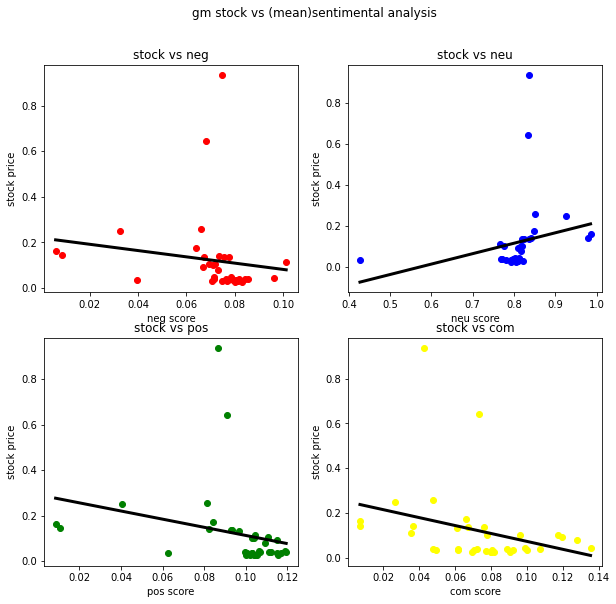

In [29]:
#plot the new gm model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (mean)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_mean = gm_merge_pred1_mean.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_mean[['neg']],gm_sort_neg_mean[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_mean[['neg']], gm_sort_neg_mean[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_mean = gm_merge_pred1_mean.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_mean[['neu']],gm_sort_neu_mean[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_mean[['neu']], gm_sort_neu_mean[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_mean = gm_merge_pred1_mean.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_mean[['pos']],gm_sort_pos_mean[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_mean[['pos']], gm_sort_pos_mean[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_mean = gm_merge_pred1_mean.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_mean[['com']],gm_sort_com_mean[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_mean[['com']], gm_sort_com_mean[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with median sentimental analysis

In [30]:
#Training models based on the gm data for four features(neg,neu,pos,com) separately
reg_gm_neg_median = LinearRegression().fit(gm_merge_df_median[['neg']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_neu_median = LinearRegression().fit(gm_merge_df_median[['neu']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_pos_median = LinearRegression().fit(gm_merge_df_median[['pos']][:-10], gm_merge_df_median[['close']][:-10])
reg_gm_com_median = LinearRegression().fit(gm_merge_df_median[['com']][:-10], gm_merge_df_median[['close']][:-10])

#predict the stock price of gm using new models
pred_gm_neg_median = reg_gm_neg_median.predict(gm_merge_df_median[['neg']][-10:])
pred_gm_neu_median = reg_gm_neu_median.predict(gm_merge_df_median[['neu']][-10:])
pred_gm_pos_median = reg_gm_pos_median.predict(gm_merge_df_median[['pos']][-10:])
pred_gm_com_median = reg_gm_com_median.predict(gm_merge_df_median[['com']][-10:])

#predict on the training model to plot the data
train_gm_neg_median = reg_gm_neg_median.predict(gm_merge_df_median[['neg']][:-10])
train_gm_neu_median = reg_gm_neu_median.predict(gm_merge_df_median[['neu']][:-10])
train_gm_pos_median = reg_gm_pos_median.predict(gm_merge_df_median[['pos']][:-10])
train_gm_com_median = reg_gm_com_median.predict(gm_merge_df_median[['com']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_median = pd.concat([gm_merge_df_median[:-10], pd.DataFrame(train_gm_neg_median,columns=['pred_neg'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_neu_median,columns=['pred_neu'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_pos_median,columns=['pred_pos'])], axis=1)
gm_merge_pred1_median = pd.concat([gm_merge_pred1_median, pd.DataFrame(train_gm_com_median,columns=['pred_com'])], axis=1)

gm_merge_pred1_median

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.0,0.8315,0.0635,0.0000,0.038992,0.122315,0.119199,0.056335,0.124472
1,01/05/2021,0.0,0.8330,0.0780,0.0000,0.039341,0.122315,0.119801,0.024011,0.124472
2,01/06/2021,0.0,0.8150,0.0000,0.0000,0.042222,0.122315,0.112576,0.197893,0.124472
3,01/07/2021,0.0,0.8430,0.0000,0.0000,0.041407,0.122315,0.123814,0.197893,0.124472
4,01/08/2021,0.0,0.8165,0.0730,0.0000,0.040272,0.122315,0.113178,0.035157,0.124472
5,01/11/2021,0.0,0.8210,0.1020,0.0258,0.046820,0.122315,0.114984,-0.029491,0.046820
6,01/12/2021,0.0,0.8260,0.0820,0.0000,0.046849,0.122315,0.116991,0.015094,0.124472
7,01/13/2021,0.0,0.8390,0.0710,0.0000,0.080166,0.122315,0.122209,0.039616,0.124472
8,01/14/2021,0.0,0.8370,0.0770,0.0000,0.104929,0.122315,0.121406,0.026240,0.124472
9,01/15/2021,0.0,0.8330,0.0670,0.0000,0.092097,0.122315,0.119801,0.048533,0.124472


In [31]:
gm_score_neg_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_neg_median)
gm_score_neu_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_neu_median)
gm_score_pos_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_pos_median)
gm_score_com_median = mean_squared_error(gm_merge_df_median[['close']][-10:], pred_gm_com_median)
[gm_score_neg_median,gm_score_neu_median,gm_score_pos_median,gm_score_com_median]

[0.006405529104221597,
 0.007346630019713157,
 0.006802680067965257,
 0.00675439845929503]

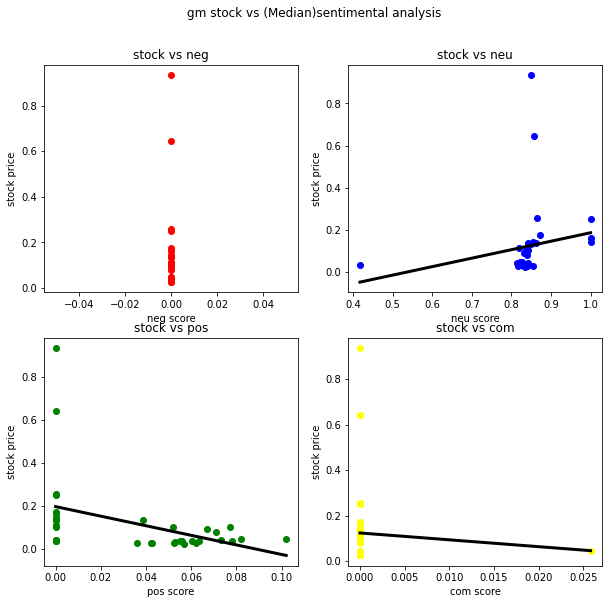

In [32]:
#plot the new gm model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Median)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_median = gm_merge_pred1_median.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_median[['neg']],gm_sort_neg_median[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_median[['neg']], gm_sort_neg_median[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_median = gm_merge_pred1_median.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_median[['neu']],gm_sort_neu_median[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_median[['neu']], gm_sort_neu_median[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_median = gm_merge_pred1_median.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_median[['pos']],gm_sort_pos_median[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_median[['pos']], gm_sort_pos_median[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_median = gm_merge_pred1_median.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_median[['com']],gm_sort_com_median[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_median[['com']], gm_sort_com_median[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with std sentimental analysis

In [33]:
#Training models based on the gm data for four features(neg,neu,pos,com) separately
reg_gm_neg_std = LinearRegression().fit(gm_merge_df_std[['neg']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_neu_std = LinearRegression().fit(gm_merge_df_std[['neu']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_pos_std = LinearRegression().fit(gm_merge_df_std[['pos']][:-10], gm_merge_df_std[['close']][:-10])
reg_gm_com_std = LinearRegression().fit(gm_merge_df_std[['com']][:-10], gm_merge_df_std[['close']][:-10])

In [34]:
#predict the stock price of gm using new models
pred_gm_neg_std = reg_gm_neg_std.predict(gm_merge_df_std[['neg']][-10:])
pred_gm_neu_std = reg_gm_neu_std.predict(gm_merge_df_std[['neu']][-10:])
pred_gm_pos_std = reg_gm_pos_std.predict(gm_merge_df_std[['pos']][-10:])
pred_gm_com_std = reg_gm_com_std.predict(gm_merge_df_std[['com']][-10:])

#predict on the training model to plot the data
train_gm_neg_std = reg_gm_neg_std.predict(gm_merge_df_std[['neg']][:-10])
train_gm_neu_std = reg_gm_neu_std.predict(gm_merge_df_std[['neu']][:-10])
train_gm_pos_std = reg_gm_pos_std.predict(gm_merge_df_std[['pos']][:-10])
train_gm_com_std = reg_gm_com_std.predict(gm_merge_df_std[['com']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_std = pd.concat([gm_merge_df_std[:-10], pd.DataFrame(train_gm_neg_std,columns=['pred_neg'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_neu_std,columns=['pred_neu'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_pos_std,columns=['pred_pos'])], axis=1)
gm_merge_pred1_std = pd.concat([gm_merge_pred1_std, pd.DataFrame(train_gm_com_std,columns=['pred_com'])], axis=1)

gm_merge_pred1_std

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,0.127590,0.181411,0.135561,0.466617,0.038992,0.102502,0.130668,0.116734,0.109848
1,01/05/2021,0.126801,0.189417,0.152984,0.449593,0.039341,0.104003,0.123670,0.078914,0.113556
2,01/06/2021,0.155863,0.235219,0.167490,0.439998,0.042222,0.048733,0.083636,0.047425,0.115646
3,01/07/2021,0.134483,0.198198,0.142393,0.419246,0.041407,0.089393,0.115995,0.101904,0.120167
4,01/08/2021,0.126382,0.181935,0.136917,0.463397,0.040272,0.104799,0.130210,0.113791,0.110549
5,01/11/2021,0.106280,0.173737,0.132980,0.441381,0.046820,0.143029,0.137375,0.122336,0.115345
6,01/12/2021,0.121252,0.173267,0.123043,0.437940,0.046849,0.114555,0.137787,0.143908,0.116095
7,01/13/2021,0.125240,0.176840,0.135958,0.429606,0.080166,0.106972,0.134663,0.115872,0.117910
8,01/14/2021,0.107212,0.164956,0.133946,0.441279,0.104929,0.141258,0.145051,0.120239,0.115367
9,01/15/2021,0.116135,0.191316,0.148472,0.433170,0.092097,0.124288,0.122010,0.088708,0.117134


In [35]:
gm_score_neg_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_neg_std)
gm_score_neu_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_neu_std)
gm_score_pos_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_pos_std)
gm_score_com_std = mean_squared_error(gm_merge_df_std[['close']][-10:], pred_gm_com_std)
[gm_score_neg_std,gm_score_neu_std,gm_score_pos_std,gm_score_com_std]

[0.006197871523401491,
 0.00535532492581497,
 0.0022690702896128014,
 0.006101762690400435]

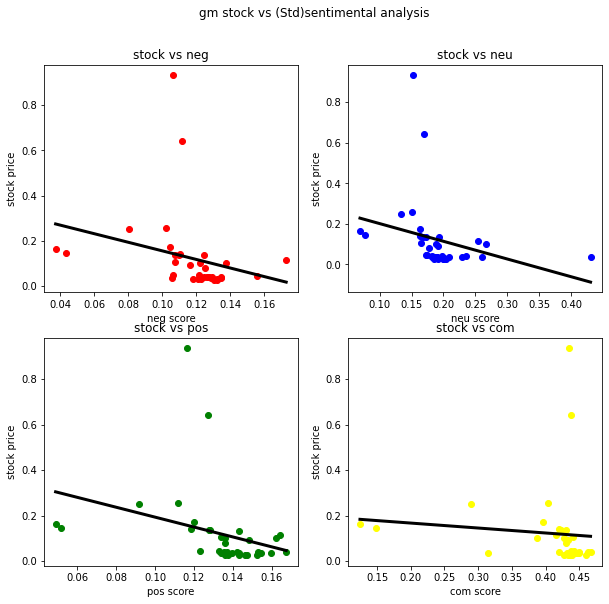

In [36]:
#plot the new gm model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Std)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_std = gm_merge_pred1_std.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_std[['neg']],gm_sort_neg_std[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_std[['neg']], gm_sort_neg_std[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_std = gm_merge_pred1_std.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_std[['neu']],gm_sort_neu_std[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_std[['neu']], gm_sort_neu_std[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_std = gm_merge_pred1_std.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_std[['pos']],gm_sort_pos_std[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_std[['pos']], gm_sort_pos_std[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_std = gm_merge_pred1_std.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_std[['com']],gm_sort_com_std[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_std[['com']], gm_sort_com_std[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()

Training with maximum sentimental analysis

In [37]:
#Training models based on the gm data for four features(neg,neu,pos,com) separately
reg_gm_neg_max = LinearRegression().fit(gm_merge_df_max[['neg']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_neu_max = LinearRegression().fit(gm_merge_df_max[['neu']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_pos_max = LinearRegression().fit(gm_merge_df_max[['pos']][:-10], gm_merge_df_max[['close']][:-10])
reg_gm_com_max = LinearRegression().fit(gm_merge_df_max[['com']][:-10], gm_merge_df_max[['close']][:-10])

In [38]:
#predict the stock price of gm using new models
pred_gm_neg_max = reg_gm_neg_max.predict(gm_merge_df_max[['neg']][-10:])
pred_gm_neu_max = reg_gm_neu_max.predict(gm_merge_df_max[['neu']][-10:])
pred_gm_pos_max = reg_gm_pos_max.predict(gm_merge_df_max[['pos']][-10:])
pred_gm_com_max = reg_gm_com_max.predict(gm_merge_df_max[['com']][-10:])

#predict on the training model to plot the data
train_gm_neg_max = reg_gm_neg_max.predict(gm_merge_df_max[['neg']][:-10])
train_gm_neu_max = reg_gm_neu_max.predict(gm_merge_df_max[['neu']][:-10])
train_gm_pos_max = reg_gm_pos_max.predict(gm_merge_df_max[['pos']][:-10])
train_gm_com_max = reg_gm_com_max.predict(gm_merge_df_max[['com']][:-10])

#combine five kinds of prediction for gm with original data
gm_merge_pred1_max = pd.concat([gm_merge_df_max[:-10], pd.DataFrame(train_gm_neg_max,columns=['pred_neg'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_neu_max,columns=['pred_neu'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_pos_max,columns=['pred_pos'])], axis=1)
gm_merge_pred1_max = pd.concat([gm_merge_pred1_max, pd.DataFrame(train_gm_com_max,columns=['pred_com'])], axis=1)

gm_merge_pred1_max

,Date,neg,neu,pos,com,close,pred_neg,pred_neu,pred_pos,pred_com
0,01/04/2021,1.000,1.0,0.811,0.9837,0.038992,0.125243,0.122315,0.038992,0.091289
1,01/05/2021,1.000,1.0,1.000,0.9928,0.039341,0.125243,0.122315,0.124696,0.165264
2,01/06/2021,1.000,1.0,1.000,0.9972,0.042222,0.125243,0.122315,0.124696,0.201032
3,01/07/2021,1.000,1.0,1.000,0.9912,0.041407,0.125243,0.122315,0.124696,0.152257
4,01/08/2021,1.000,1.0,1.000,0.9735,0.040272,0.125243,0.122315,0.124696,0.008372
5,01/11/2021,0.744,1.0,1.000,0.9992,0.046820,0.079657,0.122315,0.124696,0.217290
6,01/12/2021,1.000,1.0,1.000,0.9686,0.046849,0.125243,0.122315,0.124696,-0.031460
7,01/13/2021,1.000,1.0,1.000,0.9854,0.080166,0.125243,0.122315,0.124696,0.105108
8,01/14/2021,0.822,1.0,1.000,0.9875,0.104929,0.093547,0.122315,0.124696,0.122179
9,01/15/2021,1.000,1.0,1.000,0.9919,0.092097,0.125243,0.122315,0.124696,0.157947


In [39]:
gm_score_neg_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_neg_max)
gm_score_neu_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_neu_max)
gm_score_pos_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_pos_max)
gm_score_com_max = mean_squared_error(gm_merge_df_max[['close']][-10:], pred_gm_com_max)
[gm_score_neg_max,gm_score_neu_max,gm_score_pos_max,gm_score_com_max]

[0.006881395028616599,
 0.006405529104221597,
 0.006791102338614725,
 0.008445023931537055]

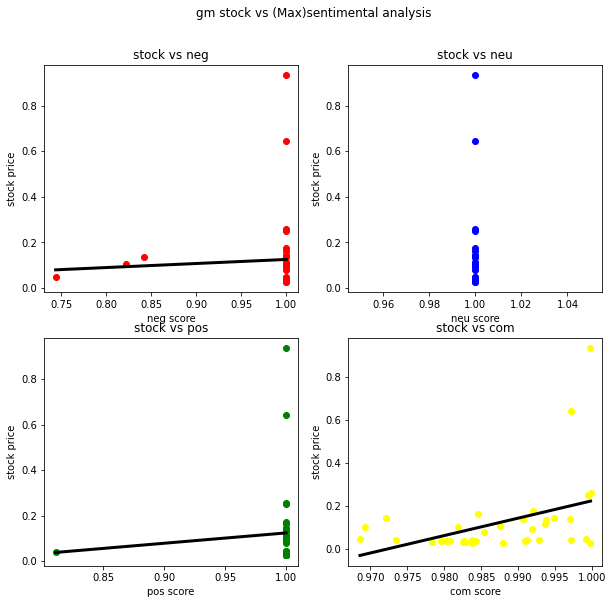

In [40]:
#plot the new gm model
#In this part, it is plotting the data with the stock + the model itself
fig, axs = plt.subplots(2,2)
plt.subplots_adjust(bottom=0.01)
fig.suptitle('gm stock vs (Max)sentimental analysis')
fig.set_size_inches(10,8)

gm_sort_neg_max = gm_merge_pred1_max.sort_values(by=['neg'])
axs[0,0].scatter(gm_sort_neg_max[['neg']],gm_sort_neg_max[['close']],color='red',label='neg') #Plotting the data
axs[0,0].plot(gm_sort_neg_max[['neg']], gm_sort_neg_max[['pred_neg']], color='black', linewidth=3) #plotting the model by using the prediction
axs[0,0].set_title('stock vs neg')
axs[0,0].set(xlabel='neg score', ylabel='stock price')

gm_sort_neu_max = gm_merge_pred1_max.sort_values(by=['neu'])
axs[0,1].scatter(gm_sort_neu_max[['neu']],gm_sort_neu_max[['close']],color='blue',label='neu') #Plotting the data
axs[0,1].plot(gm_sort_neu_max[['neu']], gm_sort_neu_max[['pred_neu']], color='black', linewidth=3)#plotting the model by using the prediction
axs[0,1].set_title('stock vs neu')
axs[0,1].set(xlabel='neu score', ylabel='stock price')

gm_sort_pos_max = gm_merge_pred1_max.sort_values(by=['pos'])
axs[1,0].scatter(gm_sort_pos_max[['pos']],gm_sort_pos_max[['close']],color='green',label='pos')#Plotting the data
axs[1,0].plot(gm_sort_pos_max[['pos']], gm_sort_pos_max[['pred_pos']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,0].set_title('stock vs pos')
axs[1,0].set(xlabel='pos score', ylabel='stock price')

gm_sort_com_max = gm_merge_pred1_max.sort_values(by=['com'])
axs[1,1].scatter(gm_sort_com_max[['com']],gm_sort_com_max[['close']],color='yellow',label='com')#Plotting the data
axs[1,1].plot(gm_sort_com_max[['com']], gm_sort_com_max[['pred_com']], color='black', linewidth=3)#plotting the model by using the prediction
axs[1,1].set_title('stock vs com')
axs[1,1].set(xlabel='com score', ylabel='stock price')
plt.show()